In [3]:
import sys
import numpy as np
from importlib import reload
import pandas
import Parameters
import Optimizer
import Results
import Vehicle
import Check_solution
from Write_Output import *
# from matplotlib import animation, rc
# # try:
# import docplex.cp
# # except:
# #     if hasattr(sys, 'real_prefix'):
# #         #we are in a virtual env.
# #         !pip install docplex
# #     else:
# #         !pip install --user docplex
# from docplex.cp.model import *

# blocks_excel = pandas.read_excel("data/Blocks.xlsx", sheet_name=0)

param=100
args=['30', '3', '1', '2', '6', '0.5']
time_limit=360

## Parameters

NUM_BUS=int(args[0])
NUM_TRIPS_PER_EB = int(args[1])
NUM_DAYS = int(args[2])
NUM_TRIPS = int(NUM_TRIPS_PER_EB*NUM_BUS*NUM_DAYS)
NUM_NODES=NUM_TRIPS+2*NUM_BUS
num_sample = int(args[3])
NUM_BUS_PER_LANE=int(args[4])
PROP_CHG = float(args[5])
NUM_LANES=ceil(NUM_BUS/NUM_BUS_PER_LANE)
NUM_SPOTS=NUM_BUS_PER_LANE
C = int(PROP_CHG*NUM_BUS)

Params=dict()
Params['NUM_BUS']=NUM_BUS
Params['NUM_TRIPS_PER_EB']=NUM_TRIPS_PER_EB
Params['NUM_DAYS']=NUM_DAYS
Params['sample']=num_sample
Params['NUM_BUS_PER_LANE']=NUM_BUS_PER_LANE
Params['PROP_CHG']=PROP_CHG
Params['param']=param

directory= str(NUM_DAYS)+'_'+str(NUM_BUS_PER_LANE)+'_'+str(num_sample)
parent_dir = "data\\"+str(NUM_BUS) + "_bus\\" + str(NUM_TRIPS_PER_EB) + "_trips_per_bus"

path = os.path.join(parent_dir, directory)

if not os.path.exists(path):
    os.mkdir(path)

excel_path=os.path.join(path, 'results.xlsx')
write(excel_path=excel_path, Param=Params, model=None, sol=None, step='Param', exit=None, time=None)

typ = 'e2'
if typ == 'e2':
    RATE=22
else:
    RATE=24

print(NUM_DAYS)
## EBS 
EB_excel = pandas.read_csv(
    'data/Vehicles.txt', sep="\t")

rates=dict()
rate_e1=42/(3*60)
rate_e2=50*100/(380*60)
rates['e1']= rate_e1
rates['e2']= rate_e2

EBs =[]

for row in EB_excel.iterrows():
    id, typ = row[1].values
    EBs.append(Vehicle.EB(id, typ, rates[typ]))

EBs =[EBs[i] for i in range(len(EBs))]
EBs= EBs[:NUM_BUS]


block_excel= pandas.read_excel("data/" + str(NUM_BUS)+ "_bus/"+str(NUM_TRIPS_PER_EB)+ "_trips_per_bus\instance_"+str(num_sample)+".xlsx", sheet_name=0)

Block = []


for h in range(NUM_DAYS):
    i=0
    for row in block_excel.iterrows():
        id, typ, start, end, ei = row[1].values
        b = Parameters.Blocks(id+h*100000,start+h*24*60, end+h*24*60, int(ei*param), typ)
        Block.append(b)
        i+=1
Block=[Block[i] for i in range(len(Block)) if Block[i].type=="e2"]


hist=[Parameters.get_number_of_trips_at_t(Block, p) for p in range(NUM_DAYS*24*60)]

instances=dict()

if np.max(hist)>NUM_BUS:
    print(np.max(hist), NUM_BUS)
    print('infeasible')


M= Parameters.get_last_block(Block)+180

# build the model

Planning= Optimizer.Planning_model(Block, EBs, 'e2', 100, 15, C, NUM_LANES, NUM_SPOTS)
solution, link_trip_to_EB, charge_events, parking_events_for_trip, parking_events_for_bus =Planning.solve(600, False, excel_path=excel_path)

logpath = os.path.join(path, 'log_output.txt')
f = open(logpath, "w") 
f.write(solution.get_solver_log()) 
f.close() 

Planning_exit=Results.Results_planning(NUM_BUS, NUM_TRIPS, NUM_LANES, NUM_SPOTS, C, RATE, param, M, EBs, Block, link_trip_to_EB, charge_events, parking_events_for_trip, parking_events_for_bus)

if not Check_solution.check_solution(Planning_exit):
                print('ERROOOOOR' + str(args))

1

Solving model....
0:01:34.794792
True


In [4]:
solution.get_solve_status(), solution.get_solve_time()

('Feasible', 9.436)

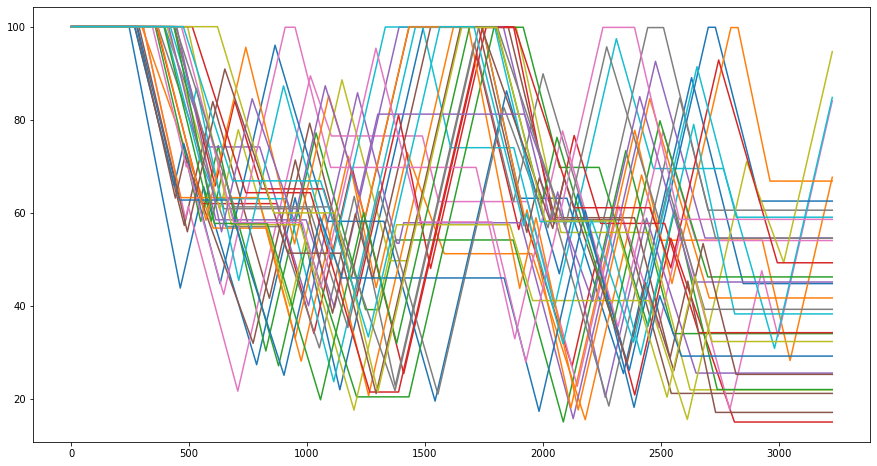

In [ ]:
reload(Vehicle)
reload(Results)
import Check_solution
reload(Check_solution)

# Planning_exit=Results.Results_planning(NUM_BUS, NUM_TRIPS, NUM_LANES, NUM_SPOTS, C, RATE, param, M, EBs, Block, link_trip_to_EB, charge_events, parking_events_for_trip, parking_events_for_bus)

Check_solution.check_solution(Planning_exit)
Planning_exit.plot_energies()

In [ ]:
for trip in range(NUM_TRIPS):
    count=0
    for bus in range(NUM_BUS):
        if trip in Planning_exit.planning[bus]:
            count+=1
    if count!=1:
        print('error')

In [ ]:
import pygame
from pygame.locals import *

def run(planning):
    FPS =1
    pygame.init()
    fpsClock=pygame.time.Clock()

    number_of_parking_lanes=planning.NUM_LANES
    number_of_spaces=planning.NUM_SPOTS
    unit_height=100
    unit_width =80

    SCREEN_WIDTH, SCREEN_HEIGHT = (number_of_parking_lanes+2)*unit_width, (number_of_spaces+1)*unit_height
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT), 0, 32)
    surface = pygame.Surface(screen.get_size())
    surface = surface.convert()
    surface.fill((255,255,255))


    class Lane(object):
        def __init__(self, lane_number):
            self.font = pygame.font.Font(None, 35)
            self.color = (0,0,0)
            self.lane_number= lane_number
            self.positions =  [((lane_number+1)*unit_width, unit_height)]

        def draw(self, surf):
            pygame.draw.rect(surf, self.color, (self.positions[0][0], self.positions[0][1], unit_width, number_of_spaces*unit_height),3)
            pygame.draw.rect(surf, self.color, (self.positions[0][0], 0, unit_width, unit_height),3)
            surface.blit(self.font.render('N°' + str(self.lane_number), True, (255,0,0)), (self.positions[0][0]+unit_width/4, unit_height/2, unit_width, unit_height))

    class Parking_space(object):
        def __init__(self, lane_number, space_number):
            self.color = (0,0,0)
            self.lane_number= lane_number
            self.space_number= space_number
            self.font = pygame.font.Font(None, 35)
            self.font_small = pygame.font.Font(None, 20)

        def draw(self, surf, t):
            pos_x = (self.lane_number+1)*unit_width
            pos_y= (self.space_number+1)*unit_height
            EB = planning.get_parking_at_spaces_at_t(self.lane_number, self.space_number,t)
            if EB != None:
                if EB.is_charged_at_t(t):
                    pygame.draw.rect(surf, (0,255,0), (pos_x, pos_y, unit_width, unit_height))
                pygame.draw.rect(surf, self.color, (pos_x, pos_y, unit_width, unit_height),1)
                surface.blit(self.font.render('EB', True, (0,0,0)), (pos_x+unit_width/4, pos_y+unit_height/10, unit_width, unit_height))
                surface.blit(self.font.render(str(EB.id), True, (0,0,0)), (pos_x+unit_width/20, pos_y+3*unit_height/10, unit_width, unit_height))
                surface.blit(self.font_small.render('SoC='+ str(np.round(EB.energy[t],1)) + '%', True, (0,0,0)), (pos_x+unit_width/20, pos_y+6*unit_height/10, unit_width, unit_height))
            else:
                pygame.draw.rect(surf, self.color, (pos_x, pos_y, unit_width, unit_height),1)

    if __name__ == '__main__':
        time_limit=planning.M-10
        Parking_lanes=[]
        Parking_spaces=[]
        for n in range(number_of_parking_lanes):
            Parking_lanes.append(Lane(n))
            for s in range(number_of_spaces):
                Parking_spaces.append(Parking_space(n, s))

        time=200
        running=True
        stop=False
        while running and time <time_limit:
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == KEYDOWN:
                    if event.key == K_SPACE:
                        stop= not stop
                    elif event.key == K_LEFT:
                        if FPS >=2:
                            FPS-=1
                    elif event.key == K_RIGHT:
                        FPS+=1
                    elif stop and event.key == K_UP:
                        time+=20
                    elif stop and event.key == K_DOWN:
                        time-=20

            surface.fill((255,255,255))
            for lane in Parking_lanes:
                lane.draw(surface)

            for space in Parking_spaces:
                space.draw(surface, time)

            screen.blit(surface, (0,0))
            font = pygame.font.Font(None, 36)
            text = font.render(str(time), 1, (10, 10, 10))
            textpos = text.get_rect()
            textpos.centerx = 20
            surface.blit(text, textpos)
            screen.blit(surface, (0,0))

            pygame.display.flip()
            pygame.display.update()
            if not stop:
                time+=1
            fpsClock.tick(FPS)
        if time ==time_limit:
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
        pygame.display.quit()
        pygame.quit()

pygame 2.4.0 (SDL 2.26.4, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
run(Planning_exit)